# 

In [1]:
import sys
import datetime
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import (
    MultilabelStratifiedKFold
)
from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_class_weight

# import PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from torch.utils.data import (
    DataLoader,
    Subset
)

# import PyTorch Modules for ComputerVision.
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
from torchvision.io import read_image
from torchvision.models import resnet18

sys.path.append("../src/")
plt.rcParams["savefig.bbox"] = 'tight'
plt.ion()   # interactive mode
cudnn.benchmark = True


In [2]:
# my modules for RSNA2023.
from dataset_handler import AbdominalTraumaDataset
from model import MultiAbdominalTraumaClassifier


In [3]:
# utilities.
def make_datalodaers(
    train_dataset,
    valid_dataset,
    batch_size: int = 4,
    shuffle: bool = True,
) -> dict[DataLoader]:
    
    return dict(
        train = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle),
        valid = DataLoader(valid_dataset, batch_size=batch_size, shuffle=shuffle)
    )

def torch_fix_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms = True


torch_fix_seed()


In [4]:
start_time = datetime.datetime.today().strftime("%Y%m%d%H%M")
save_dir = Path(rf"D:\RSNA2023\data\out\models\baseline\{start_time}")
save_dir.mkdir(parents=True, exist_ok=True)

num_epoch = 20
learning_rate = 1e-4
batch_size = 128
n_split = 5
random_state = 0
local_test_patients = -500  # Select 500 people from the back

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
train_image_root_dir = Path(
    r"D:\RSNA2023\data\train_images"
)

patient_info = pd.read_csv(
    r"D:\RSNA2023\data\train.csv"
)
patient_series = pd.read_csv(
    r"D:\RSNA2023\data\train_series_meta.csv"
)

train_patient_info = patient_info.iloc[:local_test_patients, :].copy()
train_patient_series = patient_series.query(
    "patient_id in @train_patient_info.patient_id.values"
)

test_patient_info = patient_info.iloc[local_test_patients:, :].copy()
test_patient_series = patient_series.query(
    "patient_id in @test_patient_info.patient_id.values"
)


In [6]:
# calc class weights..
data = patient_series.merge(patient_info)
data["kidney_injury"] = data["kidney_low"] + (data["kidney_high"] * 2)
data["liver_injury"] = data["liver_low"] + (data["liver_high"] * 2)
data["spleen_injury"] = data["spleen_low"] + (data["spleen_high"] * 2)

target_labels = [
    "bowel_injury",
    "extravasation_injury",
    "kidney_injury",
    "liver_injury",
    "spleen_injury",
    "any_injury",
    "incomplete_organ",
]

class_weights = {}
for label in target_labels:
    class_weights[label] = torch.from_numpy(compute_class_weight(
        class_weight="balanced",
        classes=np.sort(data.loc[:, label].unique()),
        y=data.loc[:, label].values
    ).astype(np.float32))
    print(
        f"{label} weights: " +
        ", ".join(str(_.item()) for _ in class_weights[label])
    )


bowel_injury weights: 0.5112871527671814, 22.649038314819336
extravasation_injury weights: 0.534005880355835, 7.851666450500488
kidney_injury weights: 0.3547974228858948, 8.922348022460938, 14.40672779083252
liver_injury weights: 0.3707113564014435, 4.089409828186035, 17.256410598754883
spleen_injury weights: 0.3769403100013733, 4.969409465789795, 6.857350826263428
any_injury weights: 0.6881390810012817, 1.82880437374115
incomplete_organ weights: 0.5355843305587769, 7.525558948516846


In [7]:
# Make dataset for RSNA2023 AbdominalTrauma.
dataset = AbdominalTraumaDataset(
    train_patient_info,
    train_patient_series,
    train_image_root_dir,
    img_extension=".png",
    has_pseudo3D_img=True
)


# dataset split by multilabel stratified split.
data_spliter = MultilabelStratifiedKFold(
    n_splits=n_split,
    shuffle=True,
    random_state=0,
)

# baseline model trained by 1fold.
train_indices, valid_indices = next(
    data_spliter.split(dataset.labels, dataset.labels)
)

train_dataset = Subset(dataset, train_indices)
train_dataset.dataset.transform = nn.Sequential(
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomAdjustSharpness(1.80, p=0.5),
    transforms.RandomErasing(p=0.5, scale=(0.001, 0.005), ratio=(1, 1)),
    transforms.ConvertDtype(),
    transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
)

valid_dataset = Subset(dataset, valid_indices)
valid_dataset.dataset.transform = nn.Sequential(
    transforms.Resize((224, 224), antialias=True),
    transforms.ConvertDtype(),
    transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
)


In [8]:
dataloaders = make_datalodaers(
    train_dataset,
    valid_dataset,
    batch_size=batch_size
)

model = MultiAbdominalTraumaClassifier()
criterions = {
    classname: nn.CrossEntropyLoss(weight=weights.to(device))
    for classname, weights in class_weights.items()
}

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [9]:
history = model.fit(
    dataloaders, 
    criterions, 
    optimizer,
    exp_lr_scheduler, 
    num_epoch, 
    save_dir=save_dir
)

train_history = pd.DataFrame(history).T
train_history.to_csv(save_dir / "history.csv")


[Epoch: 20/20, Phase: valid]: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s, Loss=6.13]


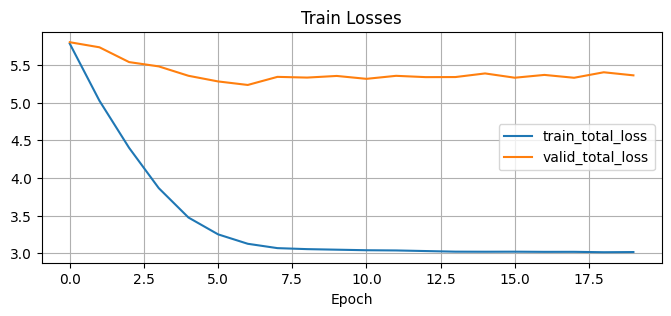

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.set_title("Train Losses")
ax.set_xlabel("Epoch")
train_history.loc[:, ["train_total_loss", "valid_total_loss"]].plot(ax=ax)
ax.grid()

plt.close()
display(fig)


In [11]:
best_epoch = train_history.loc[:, [
    "valid_bowel_injury",
    "valid_extravasation_injury",
    "valid_kidney_injury",
    "valid_liver_injury",
    "valid_spleen_injury",
    "valid_any_injury",
]].sum(axis=1).idxmin()


In [12]:
model.load_model_state(save_dir / f"E{best_epoch:03}.pt", device)

# 📝 Score

In [13]:
def make_submission_file(pred: list[np.ndarray], patient_series: pd.DataFrame):
    predict_columns = [
        "bowel_healthy",
        "bowel_injury",
        "extravasation_healthy",
        "extravasation_injury",
        "kidney_healthy",
        "kidney_low",
        "kidney_high",
        "liver_healthy",
        "liver_low",
        "liver_high",
        "spleen_healthy",
        "spleen_low",
        "spleen_high",
        "any_healthy",
        "any_injury",
        "complete_organ",
        "incomplete_organ"
    ]
    predicted = pd.DataFrame(pred, columns=predict_columns)
    predicted = pd.concat(
        [patient_series.iloc[:, 0:2], predicted], axis=1
    )
    predicted = predicted.groupby(by="patient_id", sort=False, as_index=False).mean()

    return predicted.loc[
        : ,
        [            
            "patient_id",
            "bowel_healthy",
            "bowel_injury",
            "extravasation_healthy",
            "extravasation_injury",
            "kidney_healthy",
            "kidney_low",
            "kidney_high",
            "liver_healthy",
            "liver_low",
            "liver_high",
            "spleen_healthy",
            "spleen_low",
            "spleen_high",
        ]
    ]


In [14]:
test_dataset = AbdominalTraumaDataset(
    test_patient_info,
    test_patient_series,
    train_image_root_dir,
    img_extension=".png",
    transform=nn.Sequential(
        transforms.Resize((224, 224), antialias=True),
        transforms.ConvertDtype(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ),
    has_pseudo3D_img=True
)


In [15]:
pred_test_series = model.predict(test_dataset)
y_pred = make_submission_file(pred_test_series, test_patient_series.reset_index(drop=True))


100%|██████████| 743/743 [00:04<00:00, 182.41it/s]


In [21]:
y_pred

,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,0.983242,0.016758,0.772545,0.227455,0.960843,0.015573,0.023584,0.688389,0.268269,0.043341,0.757812,0.147758,0.094430
1,0.997906,0.002094,0.994202,0.005798,0.983089,0.008063,0.008848,0.960588,0.002699,0.036713,0.977622,0.018733,0.003645
2,0.951989,0.048011,0.726442,0.273558,0.689184,0.232683,0.078132,0.865081,0.099469,0.035449,0.641109,0.153155,0.205736
3,0.957010,0.042990,0.947196,0.052804,0.974985,0.004551,0.020464,0.928430,0.007508,0.064062,0.874055,0.110375,0.015570
4,0.990422,0.009578,0.962055,0.037945,0.907461,0.056368,0.036171,0.944972,0.038092,0.016936,0.628876,0.004074,0.367049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.989230,0.010770,0.989051,0.010949,0.984278,0.013584,0.002138,0.979404,0.016475,0.004120,0.918971,0.077278,0.003751
496,0.932376,0.067624,0.898724,0.101276,0.785784,0.070105,0.144112,0.323145,0.543091,0.133764,0.548780,0.353895,0.097325
497,0.985231,0.014769,0.834534,0.165466,0.872357,0.109903,0.017740,0.863162,0.070851,0.065987,0.581349,0.379457,0.039194
498,0.988000,0.012000,0.993757,0.006243,0.754025,0.069891,0.176084,0.389069,0.543288,0.067644,0.692024,0.275063,0.032913


In [17]:
y_true = test_patient_info.iloc[:, 1:14].copy().reset_index(drop=True)
y_true["kidney_injury"] = y_true["kidney_low"] + (y_true["kidney_high"] * 2)
y_true["liver_injury"] = y_true["liver_low"] + (y_true["liver_high"] * 2)
y_true["spleen_injury"] = y_true["spleen_low"] + (y_true["spleen_high"] * 2)
target_labels = [
    "bowel",
    "extravasation",
    "kidney",
    "liver",
    "spleen",
]


In [18]:
for target in target_labels:
    pred_cols = y_pred.columns.str.contains(target)
    print(f"{target}'s log loss: {log_loss(y_true[f'{target}_injury'], y_pred.loc[:, pred_cols])}")


bowel's log loss: 0.11653640967372286
extravasation's log loss: 0.25393132067008123
kidney's log loss: 0.2501579684646967
liver's log loss: 0.4816861068862822
spleen's log loss: 0.6100193701521177
